# Plotting mean metallicity with spatial location in the Galaxy

## Learning Goals
By the end of this tutorial, you will:
- Know how to manually retrieve SDSS astraAllStarASPCAP summary files
- Know how to create and apply masks to data based on distance and quality cuts
- Know how to do simple coordinate transformations
- Know how to make color-coded plots of Galactic Chemical trends

## Introduction
In a now well known 2015 paper, [Hayden et al.](https://ui.adsabs.harvard.edu/abs/2015ApJ...808..132H/abstract) created plots with tens of thousands of APOGEE stars showing how chemical trends changed as function of position in the Galaxy.

In this tutorial, we will show how to recreate simple versions of these plots using the SDSS DR19 data release. NOTE: we will not apply any corrections for selection function here.

## Imports
This tutorial requires three commonly used python packages, and an SDSS specific package
- _numpy_ for doing large array operations
- _matplotlib_ for plotting
- _astropy_ for reading fits table

Missing packages can be installed via `pip install numpy matplotlib astropy`

## Optional Import

As written, this tutorial uses _nmmn_ and _vorbin_to improve plot quality. This entirely optional, but the depedencies are easy to install, and are available on sciServer. They can be installed via `pip install nmmn vorbin`

To run the notebook without those dependencies, you'll need to comment out the last five lines of the imports below.

In [1]:
# load in the necessary modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord

import warnings
warnings.filterwarnings('ignore')
import nmmn.plots
import vorbin
wolfram = nmmn.plots.wolframcmap() # for Mathematica's cmap
parula = nmmn.plots.parulacmap() # for MATLAB's cmap
turbo = nmmn.plots.turbocmap() # Turbo

### Loading data from a fits file

**Where**: you can download the data --> https://data.sdss5.org/sas/dr19/spectro/astra/0.6.0/summary/astraAllStarASPCAP-0.6.0.fits.gz

**OR** if you are running this notebook on sciServer, the notebook is available at /home/idies/workspace/sdss_sas_ipl/dr19/spectro/astra/0.6.0/summary/

Below, the default loadpath is set to sciServer. If you download it locally, change loadpath as needed, e.g., "/Users/myuser/Downloads/"

Next, we'll use `astropy.fits` to load the file and choose the extension we want. In this case, BOSS data is in extension 1, but we want APOGEE data in extension 2.

In [2]:
loadpath = "/home/idies/workspace/sdss_sas_ipl/ipl-3/spectro/astra/0.6.0/summary/"
filename = "astraAllStarASPCAP-0.6.0.fits.gz"
tb = fits.open(loadpath+filename)
data = tb[2].data 
print('There are '+str(len(data))+' targets in DR 19')

There are 1505140 targets in DR 19


### Creating a useful mask for the data

Like most data products, the astraAllStarASPCAP file contains data that is not useful for various reasons. For example, the ASPCAP pipeline does not work well for very hot stars (depending on the element, stars hotter than 5500 K will begin to fail in the pipeline). 

The mask below filters for:
- snr: signal-to-noise ratio, i.e. data quality
- logg: log(G) or surface gravity, effectively the size of the star; the pipeline fails for very large and very small stars
- teff: effective temperature; the pipeline fails for very hot and very cool stars
- dist: distance; we don't need very distant stars, and we want to ignore stars with large distance errors
- mg_h/fe_h: magnesium and iron abundance; the pipeline reports -9999 when it fails to determine these values, and sometimes the pipeline has significant errors and reports unphysical values > 2, so the abs cut below covers both cases

See [Bailer-Jones 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....166..269B/abstract) for information about the distances used.

In [3]:
dist = data['r_med_photogeo']
dist_err = (data['r_hi_photogeo']-data['r_lo_photogeo'])/2.

mask = (data['snr']>50)&(data['logg']<3.5)&(data['logg']>0.)&(data['teff']>3500.)&(data['teff']<5500.)\
   &(dist<20000.)&((dist/dist_err)>5)&(data['plx']>0)&(np.abs(data['mg_h'])<2)&(np.abs(data['fe_h'])<2)

### Visualizing the data

Using the masked data, we can now visualize the data using matplotlib. We'll create three plots.

First, we'll visualize the data on the sky using sky coordinates (RA and Dec), coloring by metallicity (FE_H) to see trends in the galactic plane.

Second, we'll apply a slightly less restrictive mask to see the full $\alpha$ vs [Fe/H] plane. Since there are hundreds of thousands of points, it is useful to create a densily sampled 2D distogram instead of plotting all the points on top of one another.

Note: in a departure from SDSS IV, this ASPCAP summary file now reports abundances relative to H, so [Mg/Fe] must be calculated manually. 

Finally, we plot an HR diagram using stellar temperature (TEFF) and size (LOGG), and color this plot by [FE/H] as well to see what evolutionary stage low metallicity stars in our sample are in. 

(6.0, -1.0)

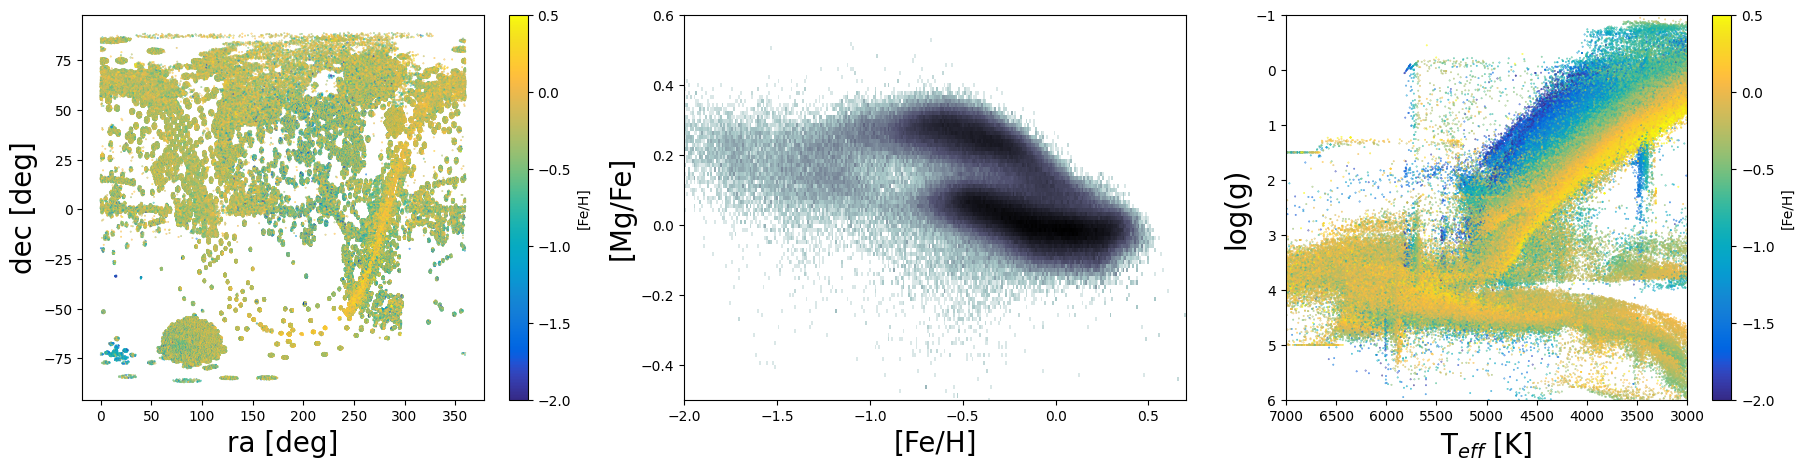

In [4]:
#visualise the data on the sky, the alpha-fe plane, and the stellar parameters
plt.figure(figsize=(22,5))

plt.subplot(1,3,1)
plt.scatter(data['RA'][mask], data['DEC'][mask], c=data['FE_H'][mask],vmin=-2,vmax=0.5,s=0.1,cmap=parula)
plt.xlabel('ra [deg]',fontsize=20)
plt.ylabel('dec [deg]',fontsize=20)
plt.colorbar(label='[Fe/H]')

#remove stars with bad stellar parameters
mask_sp = (data['TEFF']>2e3)&(data['TEFF']<7e3)&(data['LOGG']<6)&(data['LOGG']>-1)&(data['SNR']>50)\
    &(np.abs(data['MG_H'])<2)&(np.abs(data['FE_H'])<2)
plt.subplot(1,3,2)
mgfe = data['MG_H']-data['FE_H']
# plt.hist(data['FE_H'],bins=np.linspace(-2,0.5,50),histtype='step',lw=4,color='k')
# plt.hist(data['FE_H'],bins=np.linspace(-2,0.5,50),lw=4,color='k',alpha=0.3)
plt.hist2d(data['FE_H'][mask_sp&mask],mgfe[mask_sp&mask],bins=300,cmap='bone_r',norm=LogNorm())
plt.xlabel('[Fe/H]',fontsize=20)
plt.ylabel('[Mg/Fe]',fontsize=20)
plt.xlim(-2,0.7)
plt.ylim(-0.5,0.6)

plt.subplot(1,3,3)
plt.scatter(data['TEFF'][mask_sp],data['LOGG'][mask_sp], c=data['FE_H'][mask_sp],vmin=-2,vmax=0.5,s=0.1,cmap=parula)
plt.xlabel('T$_{eff}$ [K]',fontsize=20)
plt.ylabel('log(g)',fontsize=20)
plt.colorbar(label='[Fe/H]')
plt.xlim(7000,3000)
plt.ylim(6,-1)

### Coordinate transformations

As this file is already crossmatched with $Gaia$ DR3, we can compute the cylindrical positions and velocities directly from the ra, dec, pmra, pmradec, parallax, and radial velocities.

First, we create an `astropy` `SkyCoord` object with all the kinematic information we know about the star. Then we can use the coordinate object to transform to galactocentric coordinates, using the assumed values from [Schonrich et al. 2010](https://ui.adsabs.harvard.edu/abs/2010MNRAS.403.1829S/abstract), and [Gravity collab 2022](https://ui.adsabs.harvard.edu/abs/2022A%26A...657L..12G/abstract).

Finally, we'll store position and velocity arrays as new variables for later use.

In [5]:
# use skycoord to input information
c = SkyCoord(ra=data['ra'][mask]*u.deg, dec=data['dec'][mask]*u.deg, 
             distance=(1/data['plx'][mask])*u.kpc,
             pm_ra_cosdec=data['pmra'][mask]*u.mas/u.yr, 
             pm_dec=data['pmde'][mask]*u.mas/u.yr,
            radial_velocity=data['v_rad'][mask]*u.km/u.s) #dunno where the APOGEE RVs are

galcen = c.transform_to(coord.Galactocentric(galcen_v_sun=[8, 254, 8] * u.km / u.s, galcen_distance=8.275 * u.kpc))

x = galcen.x.value
y = galcen.y.value
z = galcen.z.value

vx = galcen.v_x.value
vy = galcen.v_y.value
vz = galcen.v_z.value

### Recreating "The Hayden Plot"

We have almost everything we need to recreate the many panel plot from Hayden et al. We need to decide on bins. For convenience, the bins below are known to produce an interesting plot. We'll use 7 bin edges in R, from $R_{GC} = 0$ to $R_{GC} = 12$, and 4 bin edges in Z, from $Z = -3$ to $Z = 3$, created a 6 by 3 panel plot (total bins is one less than total bin edges). We'll then create the `matplotlib` axes objects to plot on.

Now we just need to plot the stars in each bin. Since we have rows and columns, a nested for-loop is the easiest way to cover everything. So we loop through the 3 vertical "Z" bins, using enumerate to get an index we can use to select the axes object to plot on, then we similarly loop through the 6 R bins.

Within each loop iteration, the mask_loop variable is created to select only stars in the relevant bin.

Most bins have many thousands of stars, so a 2D histogram is used again.

Text(0, 0.5, '$1 < z[\\mathrm{kpc}] < 3$ \n [Mg/Fe]')

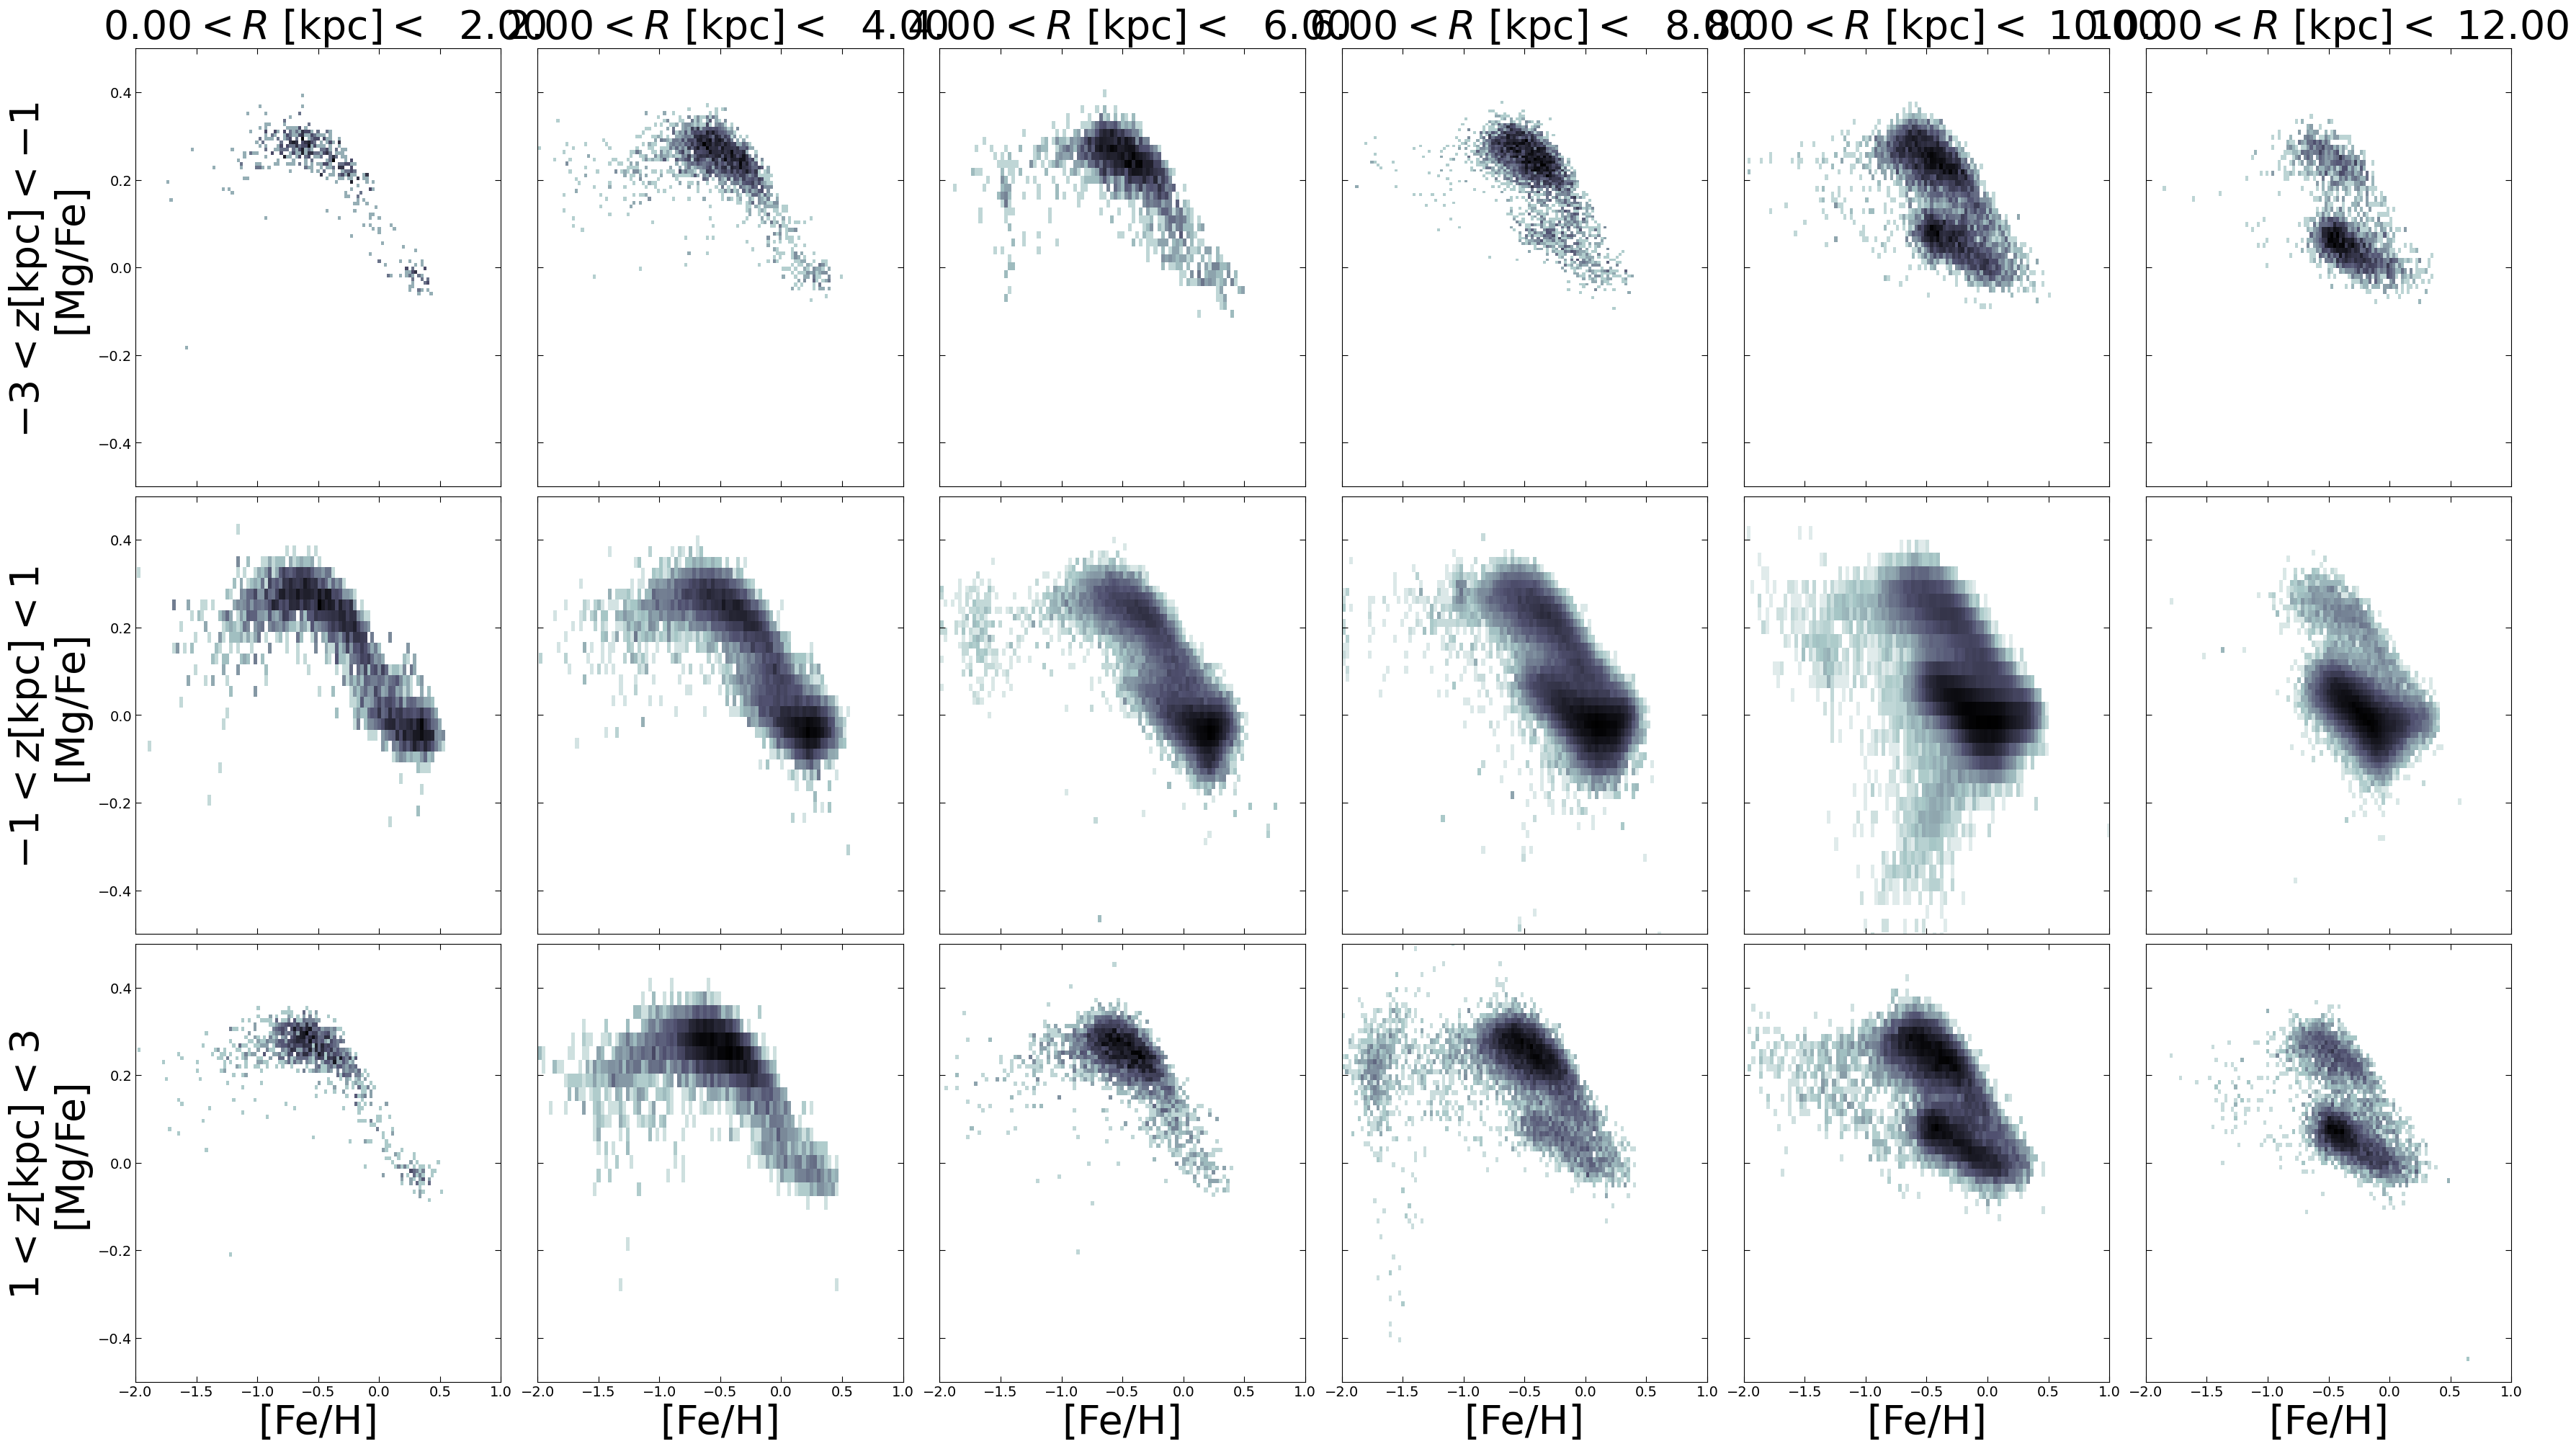

In [6]:
# plot metallicity and alpha/Fe as a function of R and z
R = np.sqrt(x**2+y**2)
rgal = np.sqrt(x**2+y**2+z**2)
# create bins in R and z
bins_R = np.linspace(0,12,7)
bins_z = np.linspace(-3,3,4)
fig, all_axes = plt.subplots(3, 6, constrained_layout=True, figsize=(35, 20), sharex=True, sharey=True)

for jndx, j in enumerate(bins_z[:-1]):
    axis = all_axes[jndx]
    for indx, i in enumerate(bins_R[:-1]):
        ax = axis[indx]
        # make the mask
        mask_loop = (R>i)&(R<bins_R[indx+1])&(z>j)&(z<bins_z[jndx+1])&(data['SNR'][mask]>50)&\
        (np.abs(data['MG_H'][mask])<2)&(np.abs(data['FE_H'][mask])<2)
        # plot
        ax.hist2d(data['FE_H'][mask][mask_loop],mgfe[mask][mask_loop],bins=100,cmap='bone_r',norm=LogNorm())
        ax.set_xlim(-2,1)
        ax.set_ylim(-0.5,0.5)
        ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=14)


all_axes[0,0].set_title(r'' +str('%5.2f' %bins_R[0])+ r'$<R$ [kpc]$<$ '+str('%5.2f' %bins_R[1]),fontsize=40)
all_axes[0,1].set_title(r'' +str('%5.2f' %bins_R[1])+ r'$<R$ [kpc]$<$ '+str('%5.2f' %bins_R[2]),fontsize=40)
all_axes[0,2].set_title(r'' +str('%5.2f' %bins_R[2])+ r'$<R$ [kpc]$<$ '+str('%5.2f' %bins_R[3]),fontsize=40)
all_axes[0,3].set_title(r'' +str('%5.2f' %bins_R[3])+ r'$<R$ [kpc]$<$ '+str('%5.2f' %bins_R[4]),fontsize=40)
all_axes[0,4].set_title(r'' +str('%5.2f' %bins_R[4])+ r'$<R$ [kpc]$<$ '+str('%5.2f' %bins_R[5]),fontsize=40)
all_axes[0,5].set_title(r'' +str('%5.2f' %bins_R[5])+ r'$<R$ [kpc]$<$ '+str('%5.2f' %bins_R[6]),fontsize=40)

for ax in all_axes[-1]:
    ax.set_xlabel('[Fe/H]',fontsize=40)
all_axes[0,0].set_ylabel('$-3 < z[\mathrm{kpc}] < -1$ \n [Mg/Fe]',fontsize=40)
all_axes[1,0].set_ylabel('$-1 < z[\mathrm{kpc}] < 1$ \n [Mg/Fe]',fontsize=40)
all_axes[2,0].set_ylabel('$1 < z[\mathrm{kpc}] < 3$ \n [Mg/Fe]',fontsize=40)

### Mean metallicity and [$\alpha$/Fe] as a function of R and Z

We can also view continuous trends in metallicity and [$\alpha$/Fe] in the R vs Z plane using slight ariations of the above code

In [7]:
bins_fehs = np.linspace(-1.2,0.8,5)
print(bins_fehs)
bins_mgfe = np.linspace(-0.6,0.6,6)
print(bins_mgfe)

[-1.2 -0.7 -0.2  0.3  0.8]
[-0.6  -0.36 -0.12  0.12  0.36  0.6 ]


(-5.0, 5.0)

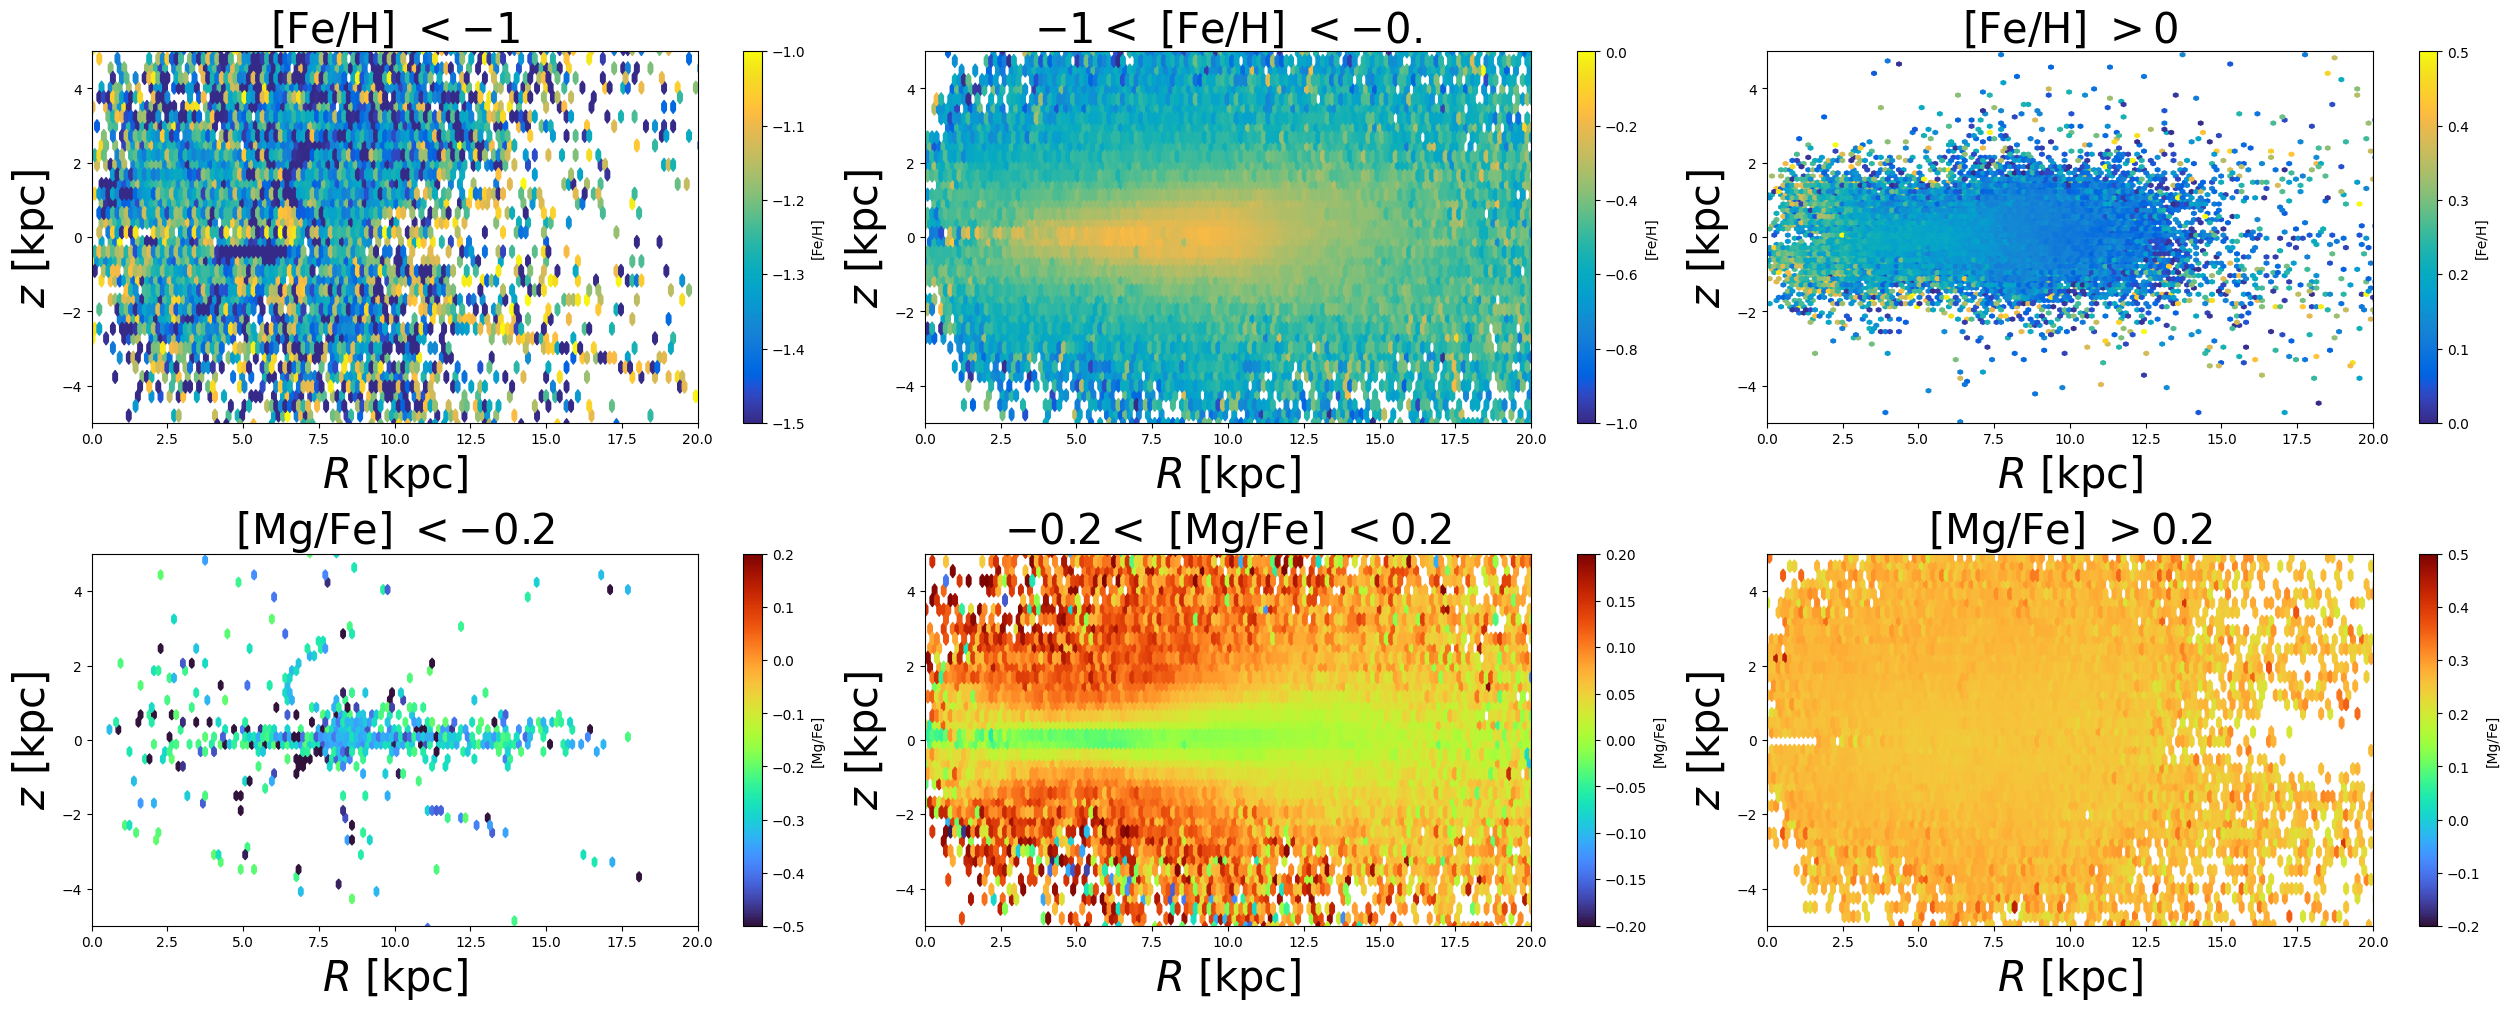

In [8]:
plt.figure(figsize=(25,10),constrained_layout = True)

plt.subplot(2,3,1)
mask_R = (np.abs(R)<30)&(np.abs(z)<30)&(data['FE_H'][mask]<-1)
plt.title('[Fe/H] $< - 1$',fontsize=30)
plt.hexbin(R[mask_R],z[mask_R],C=data['FE_H'][mask][mask_R],vmin=-1.5,vmax=-1,cmap=parula,gridsize=200)
plt.xlabel('$R$ [kpc]',fontsize=30)
plt.ylabel('$z$ [kpc]',fontsize=30)
plt.colorbar(label='[Fe/H]')
plt.xlim(0,20)
plt.ylim(-5,5)

plt.subplot(2,3,2)
mask_R = (np.abs(R)<30)&(np.abs(z)<30)&(data['FE_H'][mask]>-1)&(data['FE_H'][mask]<0)
plt.title('$-1 <$ [Fe/H] $< - 0.$',fontsize=30)
plt.hexbin(R[mask_R],z[mask_R],C=data['FE_H'][mask][mask_R],vmin=-1.,vmax=0.,cmap=parula,gridsize=200)
plt.xlabel('$R$ [kpc]',fontsize=30)
plt.ylabel('$z$ [kpc]',fontsize=30)
plt.colorbar(label='[Fe/H]')
plt.xlim(0,20)
plt.ylim(-5,5)

plt.subplot(2,3,3)
mask_R = (np.abs(R)<30)&(np.abs(z)<30)&(data['FE_H'][mask]>0)
plt.title('[Fe/H] $>  0$',fontsize=30)
plt.hexbin(R[mask_R],z[mask_R],C=data['FE_H'][mask][mask_R],vmin=-0,vmax=0.5,cmap=parula,gridsize=200)
plt.xlabel('$R$ [kpc]',fontsize=30)
plt.ylabel('$z$ [kpc]',fontsize=30)
plt.colorbar(label='[Fe/H]')
plt.xlim(0,20)
plt.ylim(-5,5)


plt.subplot(2,3,4)
mask_R = (np.abs(R)<30)&(np.abs(z)<30)&(mgfe[mask]<-0.2)
plt.title('[Mg/Fe] $< - 0.2$',fontsize=30)
plt.hexbin(R[mask_R],z[mask_R],C=mgfe[mask][mask_R],vmin=-0.5,vmax=0.2,cmap=turbo,gridsize=200)
plt.xlabel('$R$ [kpc]',fontsize=30)
plt.ylabel('$z$ [kpc]',fontsize=30)
plt.colorbar(label='[Mg/Fe]')
plt.xlim(0,20)
plt.ylim(-5,5)

plt.subplot(2,3,5)
mask_R = (np.abs(R)<30)&(np.abs(z)<30)&(mgfe[mask]>-0.2)&(mgfe[mask]<0.2)
plt.title('$-0.2 <$ [Mg/Fe] $<  0.2$',fontsize=30)
plt.hexbin(R[mask_R],z[mask_R],C=mgfe[mask][mask_R],vmin=-0.2,vmax=0.2,cmap=turbo,gridsize=200)
plt.xlabel('$R$ [kpc]',fontsize=30)
plt.ylabel('$z$ [kpc]',fontsize=30)
plt.colorbar(label='[Mg/Fe]')
plt.xlim(0,20)
plt.ylim(-5,5)

plt.subplot(2,3,6)
mask_R = (np.abs(R)<30)&(np.abs(z)<30)&(mgfe[mask]>0.2)
plt.title('[Mg/Fe] $>  0.2$',fontsize=30)
plt.hexbin(R[mask_R],z[mask_R],C=mgfe[mask][mask_R],vmin=-0.2,vmax=0.5,cmap=turbo,gridsize=200)
plt.xlabel('$R$ [kpc]',fontsize=30)
plt.ylabel('$z$ [kpc]',fontsize=30)
plt.colorbar(label='[Mg/Fe]')
plt.xlim(0,20)
plt.ylim(-5,5)

### About this notebook

This notebook was created to demonstrate basic usage of the astarAllStarASPCAP file, and how to create some well known figures using that file.

**Authors**: Danny Horta, John Donor

**Last Update**: 2024 Dec 4

If you use `astropy`  for published research, please cite the
authors. Follow this link for more information about citing `astropy`:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)

And of course please [cite](https://sdss.org/collaboration/citing-sdss/) SDSS when you use our data.